Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them


In [1]:
import retinoto_py as fovea
subset_factor = 50
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-7.5, padding_mode='zeros', seed=2025, batch_size=1, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=50, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, do_full_training=False, shuffle=True, verbose=False)

In [2]:
dataset = 'bbox'
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, do_full_preprocess=False)
val_loader = fovea.get_loader(args, val_dataset)


In [3]:
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)
model_filename

PosixPath('cached_data/32_fovea_model_name=convnext_base_dataset=bbox.pth')

In [4]:
from torchvision.transforms import v2 as transforms
npy_filename = args.data_cache / '42_likelihood_maps.npy'

# %rm {npy_filename}  # FORCING RECOMPUTE

In [5]:
resolution = (100, 100)
resolution = (30, 30)
resolution = (20, 20)
size_ratio = .4

if npy_filename.exists():
    results = fovea.np.load(npy_filename)
else:
    n_dataset = len(val_dataset)
    with fovea.torch.no_grad():
        results = fovea.np.empty((resolution[0], resolution[1], n_dataset))
        for i_batch, (image, true_idx) in fovea.tqdm(enumerate(val_loader), total=n_dataset):
            image, true_idx = image.to(args.device), true_idx.to(args.device)

            pos_H, pos_W, probas = fovea.compute_likelihood_map(args, model, image.squeeze(0), size_ratio=size_ratio, resolution=resolution)
            results[:, :, i_batch] = probas[:, true_idx].cpu().numpy().reshape(resolution)
        fovea.np.save(npy_filename, results)        

In [6]:
# fig, ax = fovea.plt.subplots()
# contour = ax.contourf(results.mean(axis=-1))
# fig.colorbar(contour, ax=ax)  # Add colorbar
# ax.axis('square')
# fig.set_facecolor(color='white')


In [7]:
results.shape

(20, 20, 1000)

In [8]:
i_image = 2
proba = results[:, :, i_image]
proba.min(), proba.max()

(np.float64(0.00027618606691248715), np.float64(0.9772347807884216))

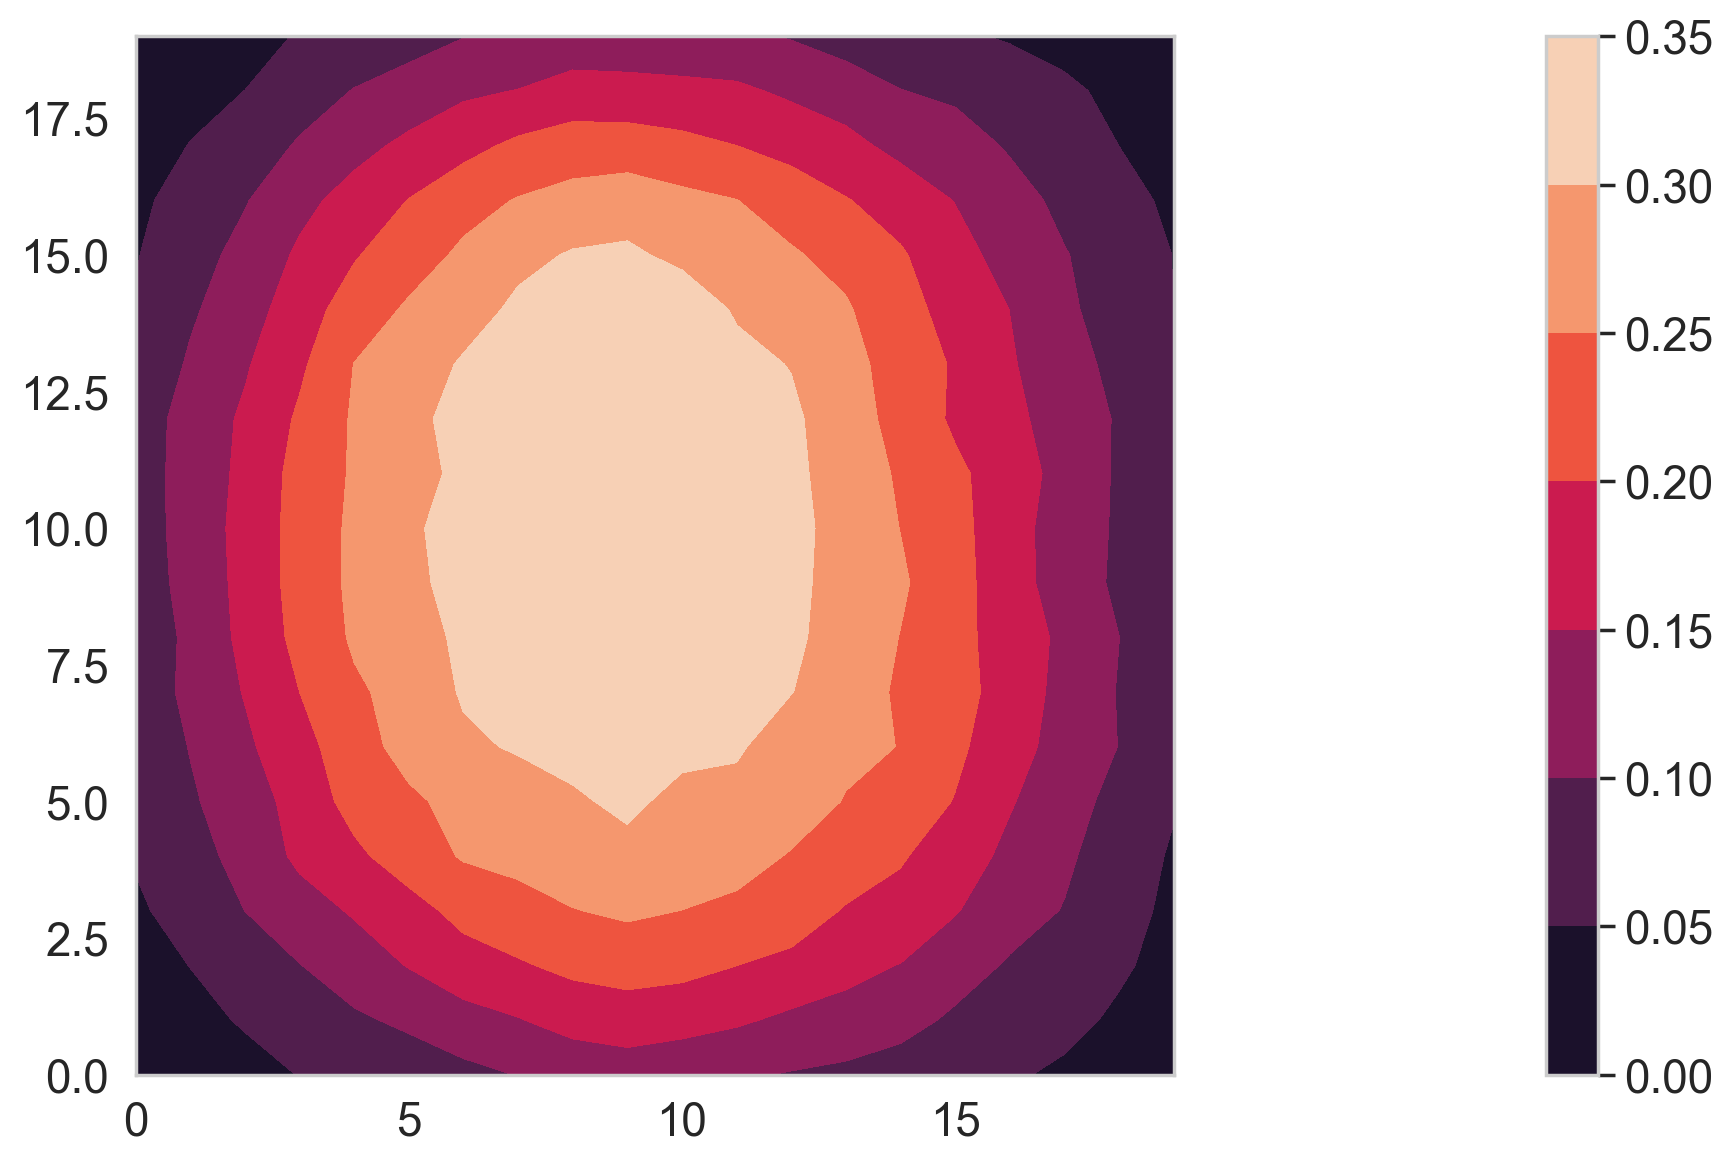

In [9]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(results.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


In [10]:
import pandas as pd
import numpy as np

pos_H, pos_W = fovea.get_positions(1, 1, resolution=resolution)
pos_H.min(), pos_H.max(), pos_W.min(), pos_W.max(), pos_H.shape, results.shape

(np.float64(0.047619047619047616),
 np.float64(0.9523809523809523),
 np.float64(0.047619047619047616),
 np.float64(0.9523809523809523),
 (400,),
 (20, 20, 1000))

In [21]:
data = []
for do_fovea in [True, False]:    
    results = fovea.np.load(npy_filename)
    data_= pd.DataFrame({
        'horizontal position': pos_H,
        'vertical position': pos_W,
        'probas': results.mean(axis=-1).T.flatten(),
        'retinotopy': 'foveated' if do_fovea else 'uniform' 
    })
    data.append(data_)
combined_data = pd.concat(data, ignore_index=True)
combined_data

,horizontal position,vertical position,probas,retinotopy
0,0.047619,0.047619,0.010559,foveated
1,0.095238,0.047619,0.018193,foveated
2,0.142857,0.047619,0.029625,foveated
3,0.190476,0.047619,0.041835,foveated
4,0.238095,0.047619,0.054293,foveated
...,...,...,...,...
795,0.761905,0.952381,0.048930,uniform
796,0.809524,0.952381,0.042639,uniform
797,0.857143,0.952381,0.032355,uniform
798,0.904762,0.952381,0.029558,uniform


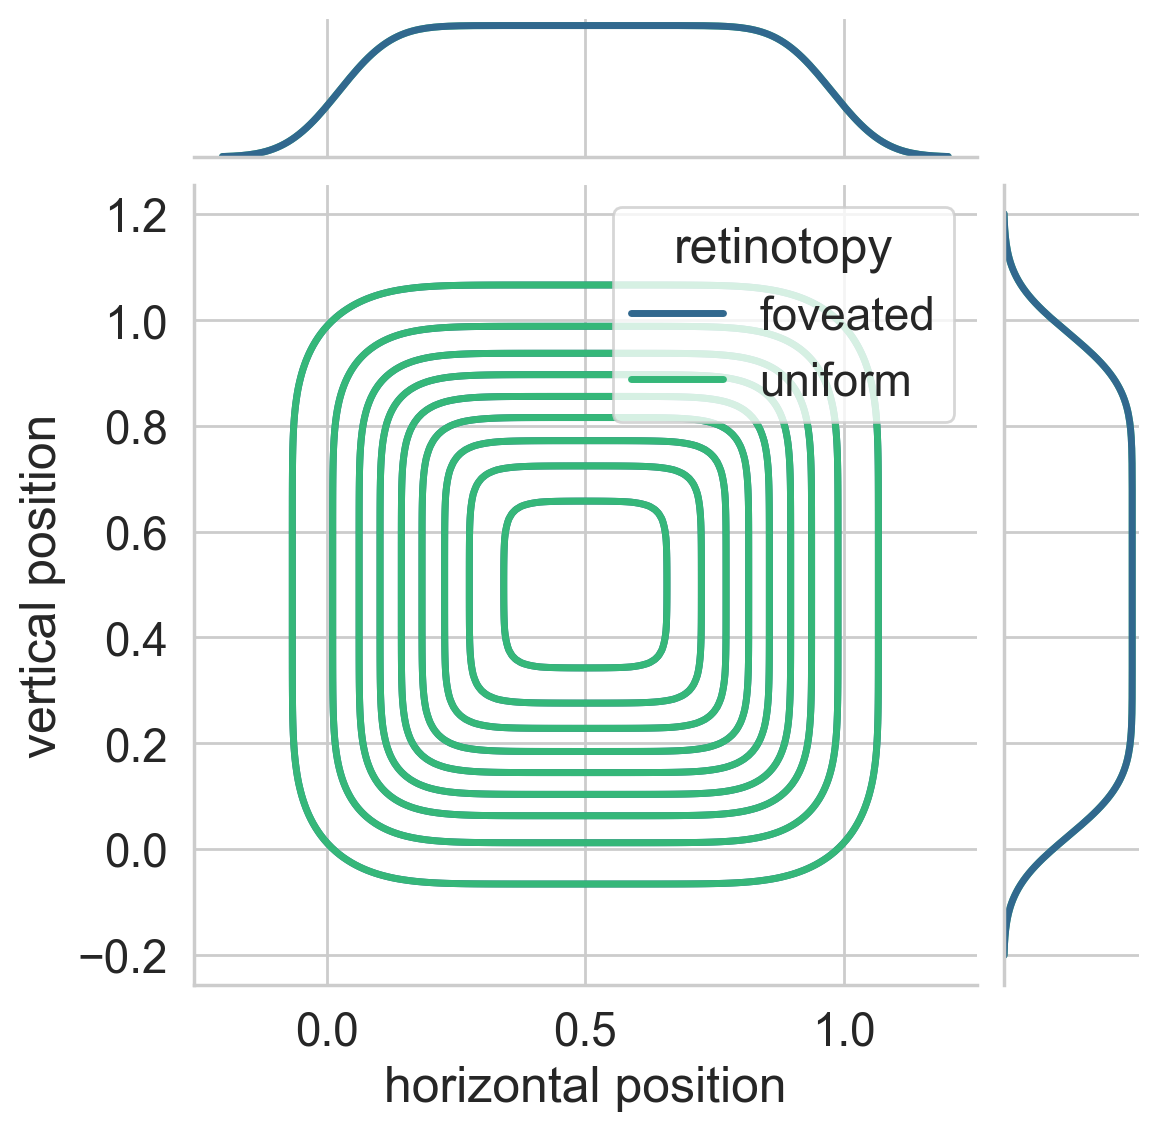

In [22]:
import seaborn as sns
sns.jointplot(
    data=combined_data,
    x="horizontal position",
    y="vertical position",
    hue="retinotopy",
    kind="kde",
    palette="viridis"
)


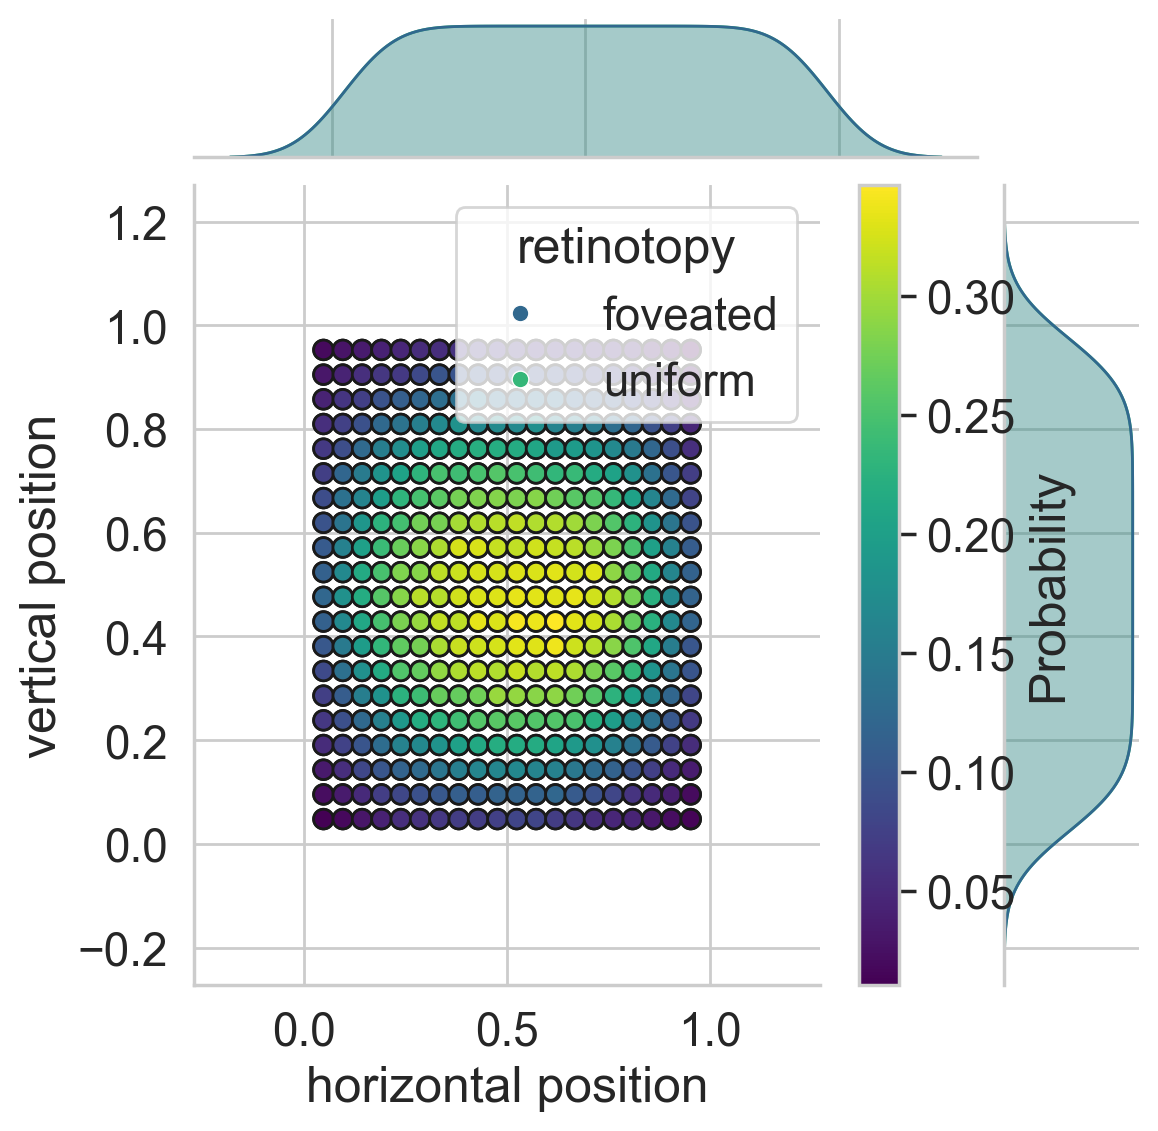

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot using jointplot with kind="scatter"
g = sns.jointplot(
    data=combined_data,
    x="horizontal position",
    y="vertical position",
    hue="retinotopy",
    palette="viridis",
    kind="scatter"
)

# Customize the plot to show proba values
g.ax_joint.scatter(
    combined_data["horizontal position"],
    combined_data["vertical position"],
    c=combined_data["probas"],
    cmap="viridis",
    s=50,
    edgecolor="k"
)

# Add a colorbar to show the probability scale
norm = plt.Normalize(combined_data["probas"].min(), combined_data["probas"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
g.fig.colorbar(sm, ax=g.ax_joint, label="Probability")

plt.show()


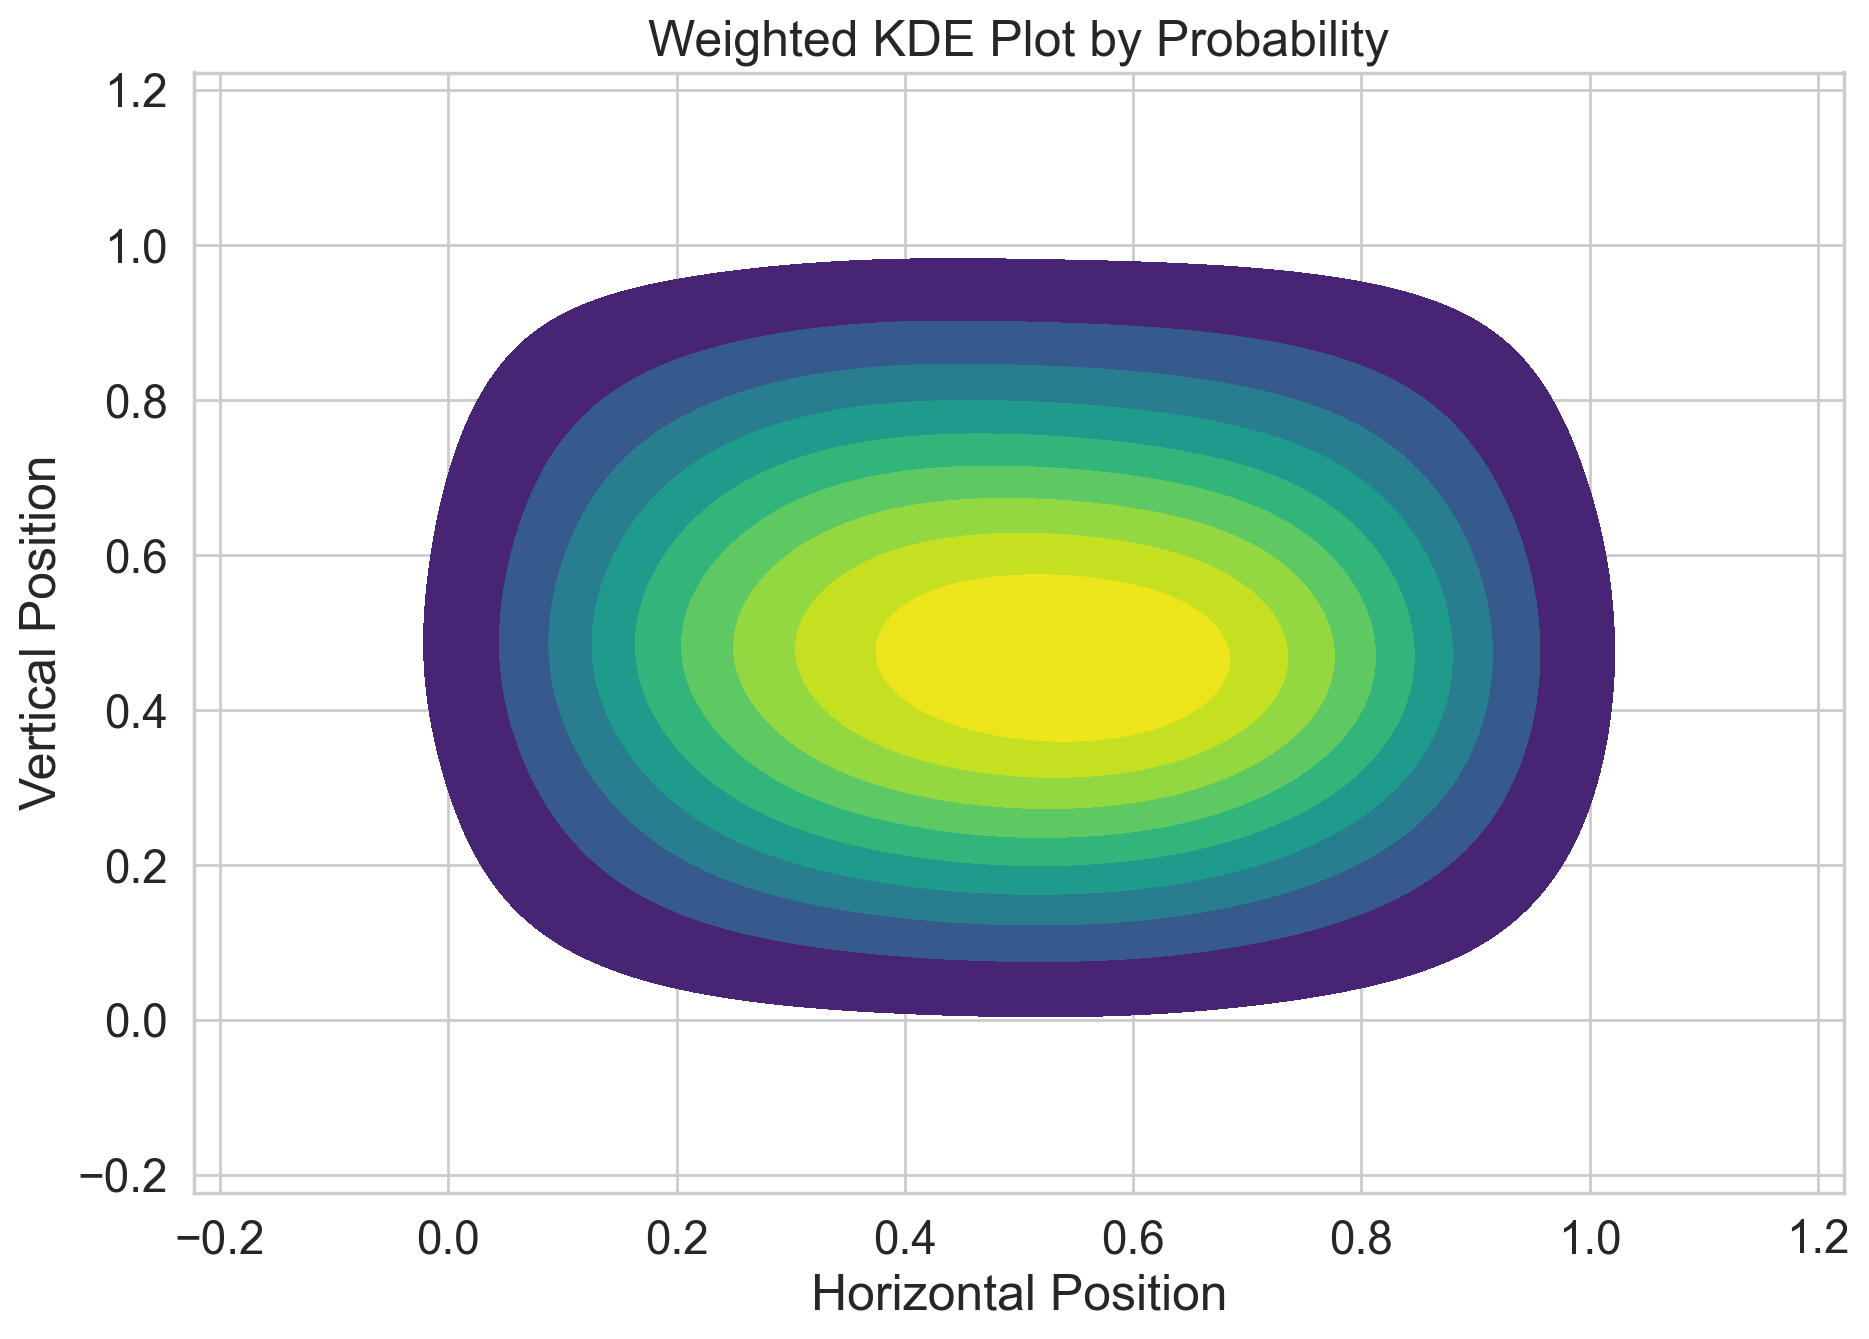

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a grid for the KDE plot
x = combined_data["horizontal position"]
y = combined_data["vertical position"]
weights = combined_data["probas"]

# Normalize the weights to sum to 1 (optional but often useful)
weights = weights / weights.sum()

# Plot the weighted KDE
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=x,
    y=y,
    weights=weights,
    levels=10,  # Number of contour levels
    cmap="viridis",
    fill=True
)

plt.title("Weighted KDE Plot by Probability")
plt.xlabel("Horizontal Position")
plt.ylabel("Vertical Position")
plt.show()


(array([ 47.,  26.,  14.,  23.,  31.,  39.,  27.,  60., 160., 573.]),
 array([0.00219904, 0.10143093, 0.20066281, 0.29989469, 0.39912657,
        0.49835845, 0.59759034, 0.69682222, 0.7960541 , 0.89528598,
        0.99451786]),
 <BarContainer object of 10 artists>)

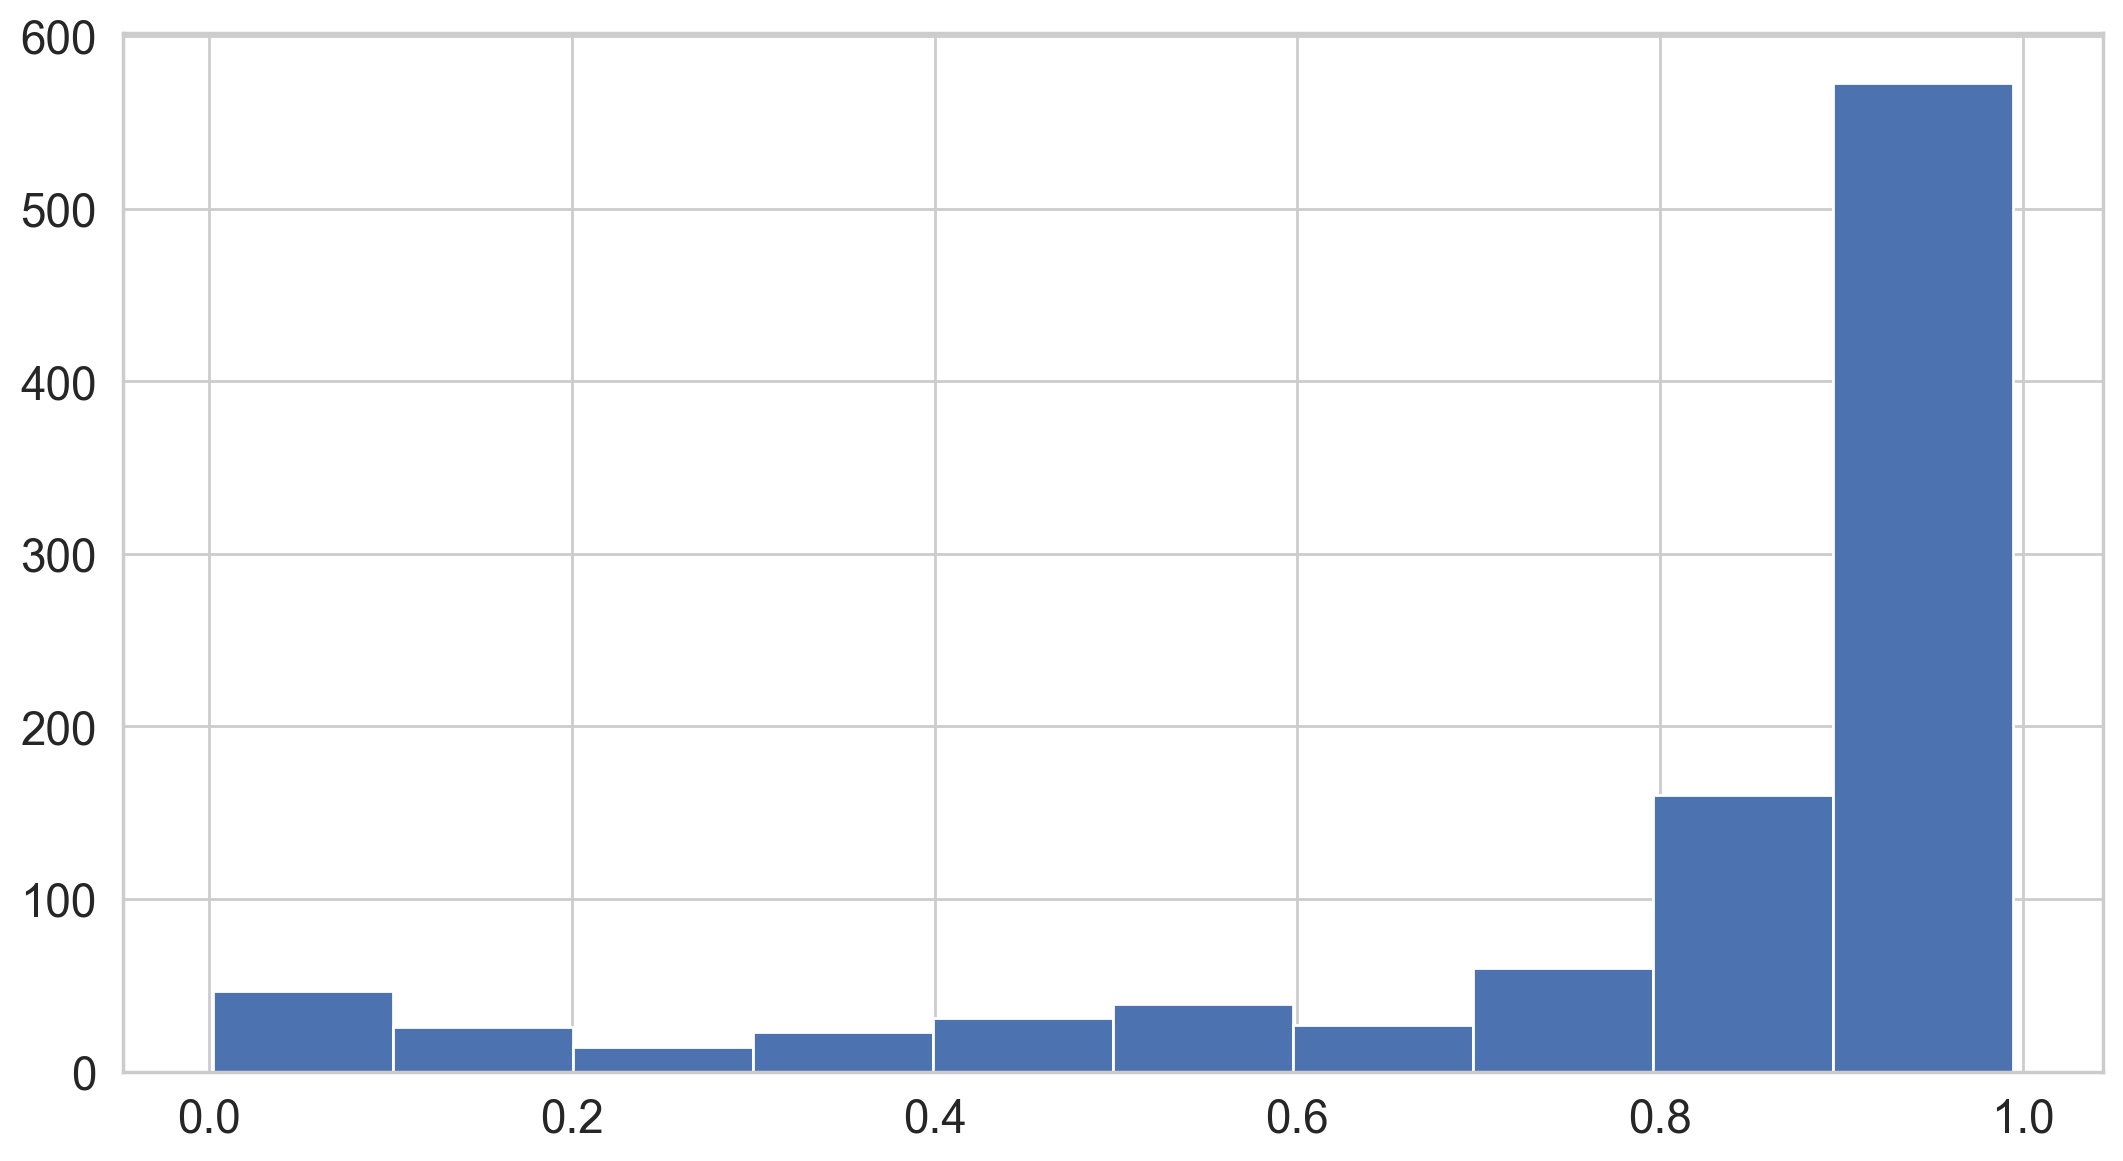

In [13]:
accuracy = results.max(axis=(0, 1))
fig, ax = fovea.plt.subplots()
ax.hist(accuracy)
